In [1]:
import sys

import tensorflow.keras
import pandas as pd
import sklearn as sk
import tensorflow as tf

print(f"Tensor Flow Version: {tf.__version__}")
print(f"Keras Version: {tensorflow.keras.__version__}")
print()
print(f"Python {sys.version}")
print(f"Pandas {pd.__version__}")
print(f"Scikit-Learn {sk.__version__}")
gpu = len(tf.config.list_physical_devices('GPU'))>0
print("GPU is", "available" if gpu else "NOT AVAILABLE")
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.applications import imagenet_utils
from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random
import matplotlib.pyplot as plt
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import layers 
import tensorflow.keras
import pandas as pd
import sklearn as sk
import tensorflow as tf
import glob 
import cv2 
import keras 


Tensor Flow Version: 2.6.0
Keras Version: 2.6.0

Python 3.9.12 (main, Apr  4 2022, 05:22:27) [MSC v.1916 64 bit (AMD64)]
Pandas 1.4.3
Scikit-Learn 1.1.1
GPU is available


In [2]:
def initiateGenerator(path):
    base_path = path
    print("\nTotal : ", end=" ")
    train_dataset = tf.keras.preprocessing.image_dataset_from_directory(batch_size=32, directory=base_path)

    train_datagen = ImageDataGenerator(validation_split=0.3)

    print("\nFor Training : ", end=" ")
    train_generator = train_datagen.flow_from_directory(
        base_path,
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical', subset='training')

    print("\nFor Val : ", end=" ")
    validation_generator = train_datagen.flow_from_directory(
        base_path,
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical',
        subset='validation', shuffle=False)

    class_names = train_dataset.class_names
    noOfClasses = len(class_names)
    print("\nNo of Classes : ", noOfClasses)
    print("Classes : ", class_names)

    plt.figure(figsize=(10, 10))
    for images, labels in train_dataset.take(1):
        for i in range(noOfClasses):
            ax = plt.subplot(4, 4, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(class_names[labels[i]])
            plt.axis("off")

    for image_batch, labels_batch in train_dataset:
        print("Image Shape : ",image_batch.shape)
        break
        
    return noOfClasses,class_names, train_generator, validation_generator

In [3]:
def initiateNormalize():
    AUTOTUNE = tf.data.AUTOTUNE

    train_ds = train_generator.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
    val_ds = val_generator.cache().prefetch(buffer_size=AUTOTUNE)
    normalization_layer = layers.Rescaling(1./255)

    normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
    image_batch, labels_batch = next(iter(normalized_ds))
    first_image = image_batch[0]
    print(np.min(first_image), np.max(first_image))

In [4]:
def initiateModel(noOfClasses):
    modelInput = tf.keras.applications.VGG16(
        input_shape=IMAGE_SIZE + [3],
        include_top=False,
        weights="imagenet"
    )
    
    for layer in modelInput.layers:
        layer.trainable = False
    
    x = Flatten()(modelInput.output)
    prediction = Dense(noOfClasses, activation='softmax')(x)

    model = Model(inputs=modelInput.input, outputs=prediction)
    return model

def modelSummary(model):
    model.summary()

In [5]:
def initiateParams(className, model, lr):
    opt = tf.keras.optimizers.Adam(learning_rate=lr)

    model.compile(optimizer=opt,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    annealer = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, verbose=1, min_lr=1e-3)
    checkpoint = ModelCheckpoint(className + 'VGG16.h5', verbose=1, save_best_only=True)
    
    return model, annealer, checkpoint

In [6]:
def modelFit(model, annealer, checkpoint, epochs=25, batchSize = 256):

    history = model.fit(
      train_generator,
      validation_data=validation_generator,
      epochs=epochs,
      batch_size=batchSize,
      callbacks=[annealer, checkpoint],
      steps_per_epoch=len(train_generator),
      validation_steps=len(validation_generator)
    )
    
    return history

In [7]:
def plotOutput(history, className, epochs):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(epochs)

    plt.figure(figsize=(12, 12))
    plt.subplot(3, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(3, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()
    plt.savefig(className + '_graph.png')

In [8]:
def evalModel(model):
    evl = model.evaluate(validation_generator)
    acc = evl[1]*100
    msg=f'Accuracy on the Test Set = {acc:5.2f} %'
    print(msg)
    
def saveModel(model, className):
    model.save(className + " - VGG16.h5")
    print("Model Saved!")

In [9]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(15, 15))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()
    plt.savefig(title + '.png')

In [10]:
def callPlot(model, className, classes):
    y_true = validation_generator.classes
    print("True : ", (y_true))

    y_pred = model.predict(validation_generator)
    y_pred = np.argmax(y_pred, axis=1)
    print("Predicted : ", (y_pred))

    conf_mat = confusion_matrix(y_true, y_pred)

    plot_confusion_matrix(cm           = conf_mat,
                          normalize    = False,
                          target_names = classes,
                          title        = className + "Confusion Matrix")

In [11]:
mpath = r'../AIDISS/Dataset/Multi Cancer'
classPaths = os.listdir(mpath)

IMAGE_SIZE = [224, 224]
img_height = 224
img_width = 224
noOfClasses = 0
gEpochs = 25
lr = 0.001

for i in classPaths:
    print(i)

ALL
ALL_RAW
BreaKHis_Total_dataset_RAW
Breast Cancer
Lung and Colon Cancer
Lung_and_Colon_Cancer_RAW
Lymphoma
Oral Cancer



Total :  Found 25000 files belonging to 5 classes.

For Training :  Found 17500 images belonging to 5 classes.

For Val :  Found 7500 images belonging to 5 classes.

No of Classes :  5
Classes :  ['colon_aca', 'colon_bnt', 'lung_aca', 'lung_bnt', 'lung_scc']
Image Shape :  (32, 256, 256, 3)
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (No


Epoch 00024: val_loss did not improve from 0.67210
Epoch 25/25
547/547 [==============================] - 84s 153ms/step - loss: 0.0953 - accuracy: 0.9982 - val_loss: 1.7113 - val_accuracy: 0.9841

Epoch 00025: val_loss did not improve from 0.67210


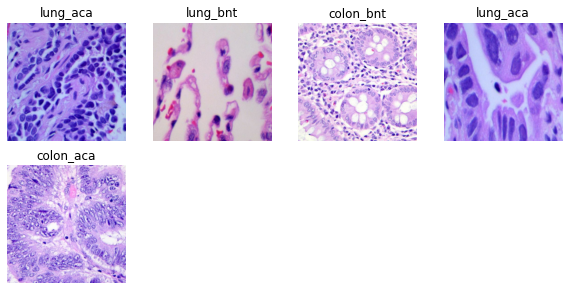

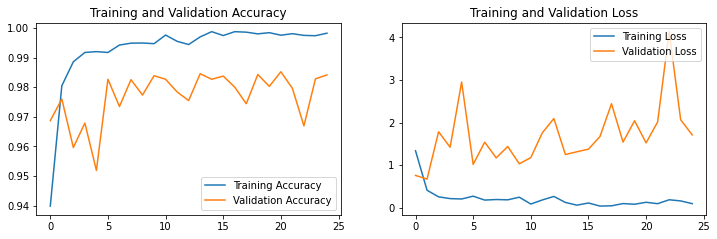

235/235 [==============================] - 26s 111ms/step - loss: 1.7113 - accuracy: 0.9841
Accuracy on the Test Set = 98.41 %
Model Saved!
True :  [0 0 0 ... 4 4 4]
Predicted :  [0 1 0 ... 4 4 4]


<Figure size 432x288 with 0 Axes>

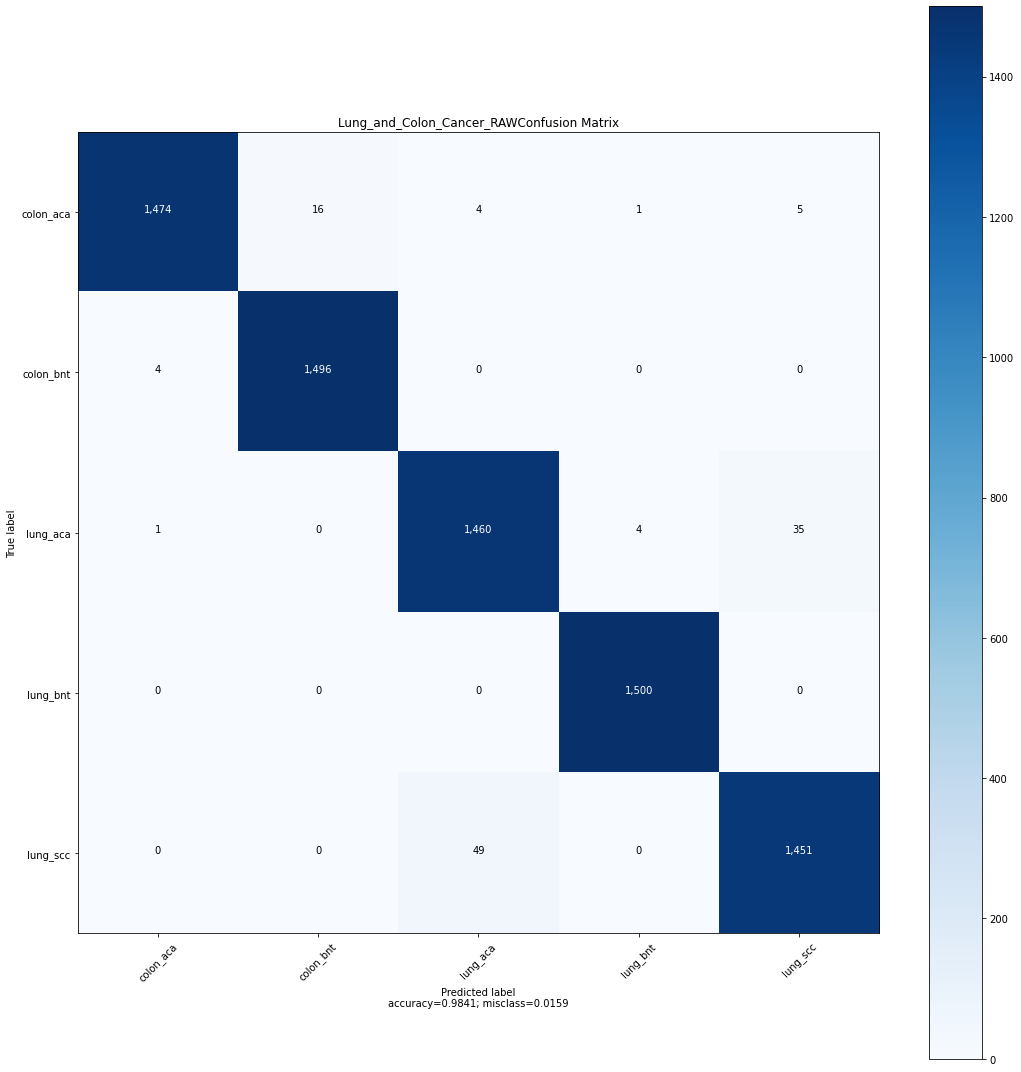

<Figure size 432x288 with 0 Axes>

In [12]:
className = 'Lung and Colon Cancer'
cpath = os.path.join(mpath, 'Lung and Colon Cancer')
noOfClasses, class_names, train_generator, validation_generator = initiateGenerator(cpath)
curModel = initiateModel(noOfClasses)
modelSummary(curModel)
curModel, annealer, checkpoint = initiateParams(className, curModel, lr)
curHistory = modelFit(curModel, annealer, checkpoint, epochs=gEpochs, batchSize=256)
plotOutput(curHistory, className, gEpochs)
evalModel(curModel)
saveModel(curModel, className)
callPlot(curModel, className, class_names)


Total :  Found 3256 files belonging to 4 classes.

For Training :  Found 2281 images belonging to 4 classes.

For Val :  Found 975 images belonging to 4 classes.

No of Classes :  4
Classes :  ['Benign', 'Early', 'Pre', 'Pro']
Image Shape :  (32, 256, 256, 3)
Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856  


Epoch 00024: val_loss did not improve from 10.62436
Epoch 25/25
72/72 [==============================] - 11s 149ms/step - loss: 9.3748e-08 - accuracy: 1.0000 - val_loss: 14.8557 - val_accuracy: 0.8277

Epoch 00025: val_loss did not improve from 10.62436


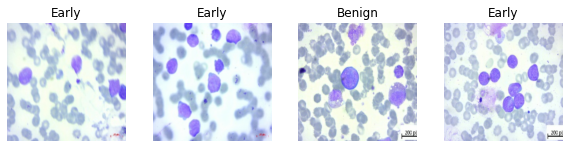

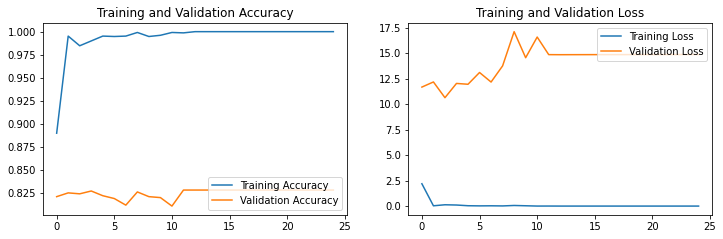

31/31 [==============================] - 3s 103ms/step - loss: 14.8557 - accuracy: 0.8277
Accuracy on the Test Set = 82.77 %
Model Saved!
True :  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 

<Figure size 432x288 with 0 Axes>

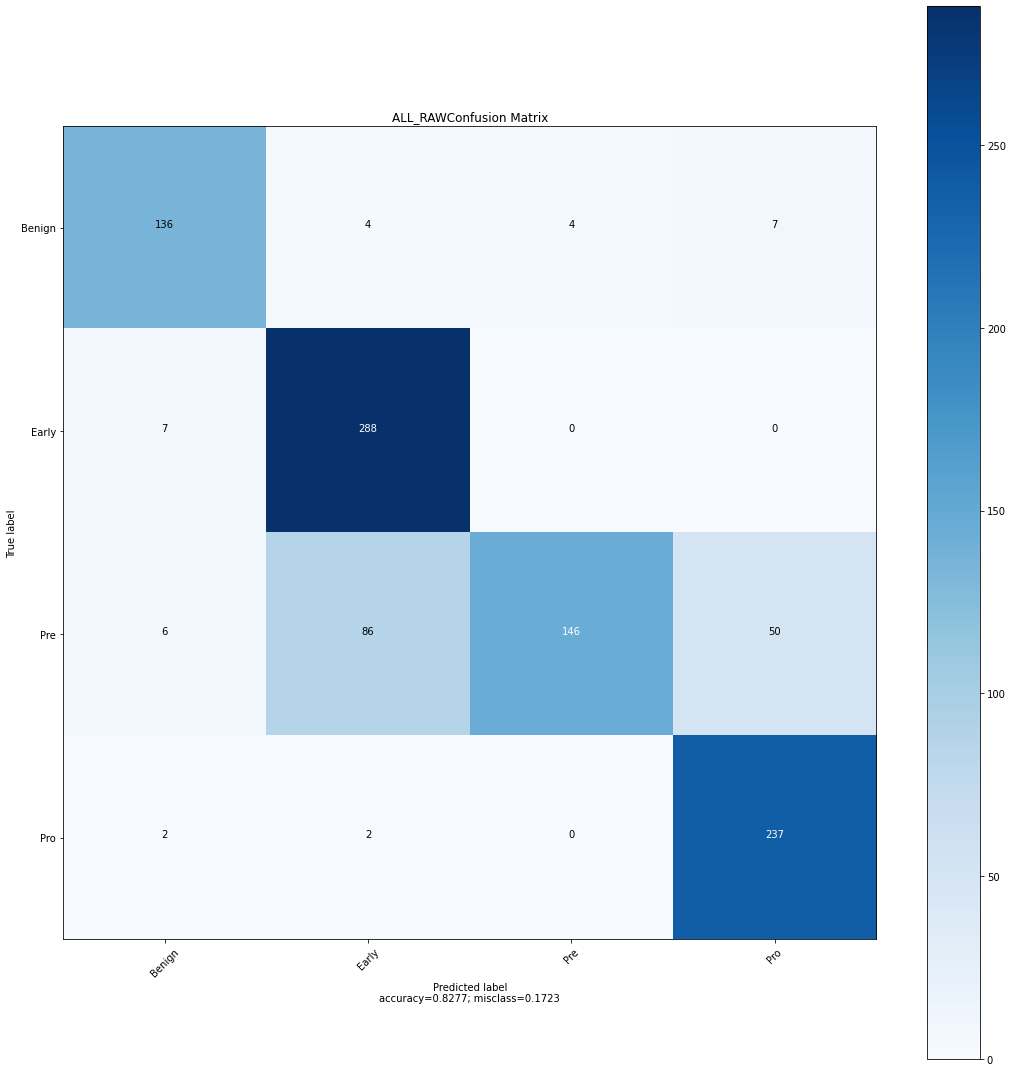

<Figure size 432x288 with 0 Axes>

In [16]:
className = 'ALL_RAW'
cpath = os.path.join(mpath, 'ALL_RAW')
noOfClasses, class_names, train_generator, validation_generator = initiateGenerator(cpath)
curModel = initiateModel(noOfClasses)
modelSummary(curModel)
curModel, annealer, checkpoint = initiateParams(className, curModel, lr)
curHistory = modelFit(curModel, annealer, checkpoint, epochs=gEpochs, batchSize=256)
plotOutput(curHistory, className, gEpochs)
evalModel(curModel)
saveModel(curModel, className)
callPlot(curModel, className, class_names)


Total :  Found 7783 files belonging to 2 classes.

For Training :  Found 5449 images belonging to 2 classes.

For Val :  Found 2334 images belonging to 2 classes.

No of Classes :  2
Classes :  ['benign', 'malignant']
Image Shape :  (32, 256, 256, 3)
Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_____

171/171 [==============================] - 56s 325ms/step - loss: 0.1407 - accuracy: 0.9906 - val_loss: 20.3572 - val_accuracy: 0.7956

Epoch 00024: val_loss did not improve from 7.16145
Epoch 25/25
171/171 [==============================] - 58s 338ms/step - loss: 0.1489 - accuracy: 0.9917 - val_loss: 20.6267 - val_accuracy: 0.7828

Epoch 00025: val_loss did not improve from 7.16145


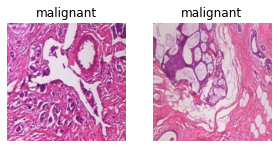

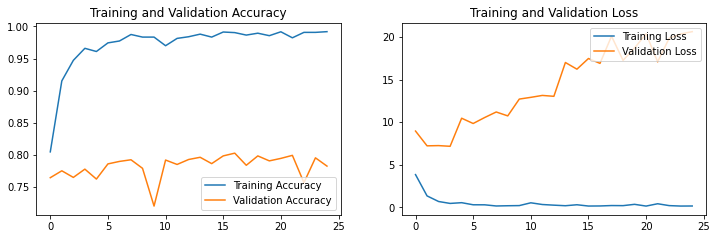

73/73 [==============================] - 17s 235ms/step - loss: 20.6267 - accuracy: 0.7828
Accuracy on the Test Set = 78.28 %
Model Saved!
True :  [0 0 0 ... 1 1 1]
Predicted :  [0 1 1 ... 1 1 1]


<Figure size 432x288 with 0 Axes>

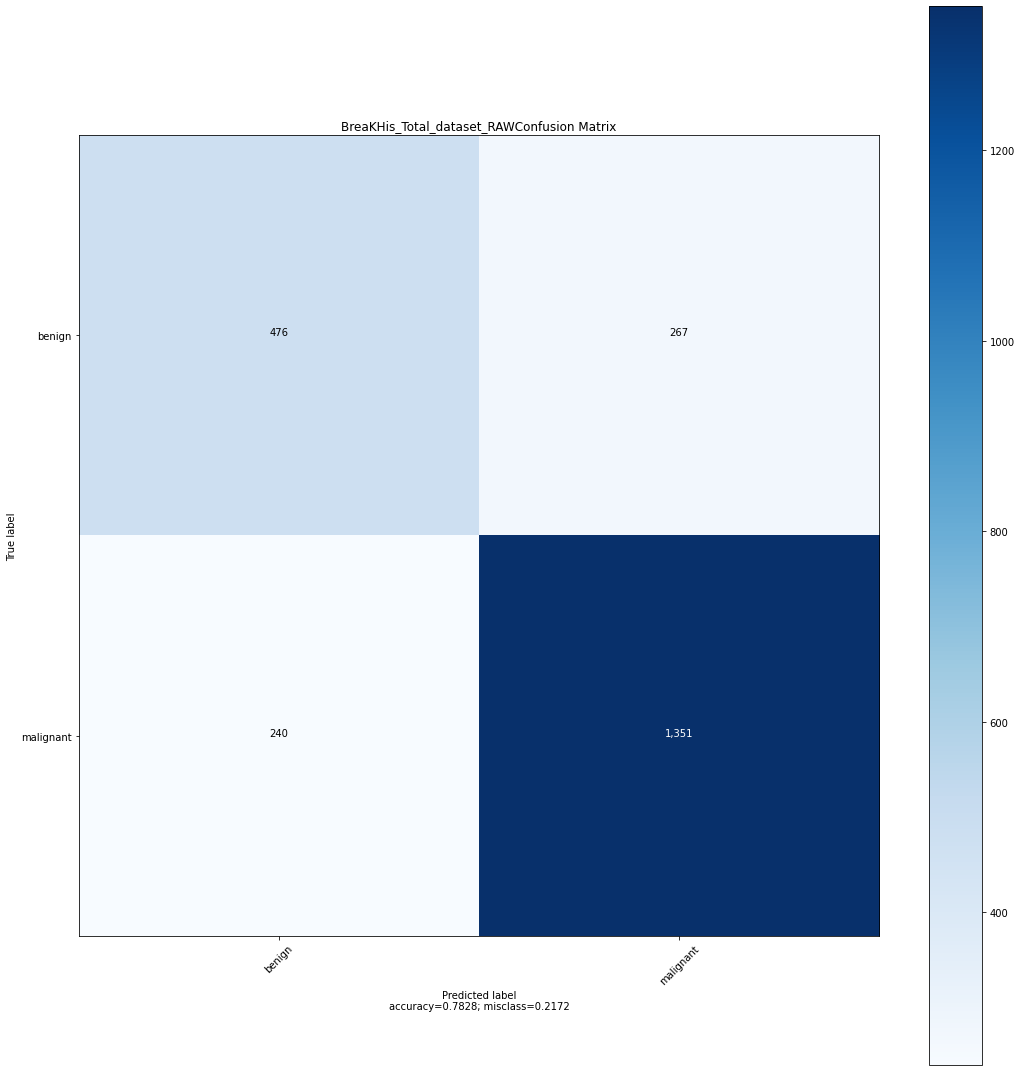

<Figure size 432x288 with 0 Axes>

In [15]:
className = 'BreaKHis_Total_dataset_RAW'
cpath = os.path.join(mpath, 'BreaKHis_Total_dataset_RAW')
noOfClasses, class_names, train_generator, validation_generator = initiateGenerator(cpath)
curModel = initiateModel(noOfClasses)
modelSummary(curModel)
curModel, annealer, checkpoint = initiateParams(className, curModel, lr)
curHistory = modelFit(curModel, annealer, checkpoint, epochs=gEpochs, batchSize=256)
plotOutput(curHistory, className, gEpochs)
evalModel(curModel)
saveModel(curModel, className)
callPlot(curModel, className, class_names)

In [ ]:
className = 'Lung and Colon Cancer '
cpath = os.path.join(mpath, 'Lung and Colon Cancer')
noOfClasses, class_names, train_generator, validation_generator = initiateGenerator(cpath)
curModel = initiateModel(noOfClasses)
modelSummary(curModel)
curModel, annealer, checkpoint = initiateParams(className, curModel, lr)
curHistory = modelFit(curModel, annealer, checkpoint, epochs=gEpochs, batchSize=256)
plotOutput(curHistory, className, gEpochs)
evalModel(curModel)
saveModel(curModel, className)
callPlot(curModel, className, class_names)


Total :  Found 10000 files belonging to 2 classes.

For Training :  Found 7000 images belonging to 2 classes.

For Val :  Found 3000 images belonging to 2 classes.

No of Classes :  2
Classes :  ['breast_benign', 'breast_malignant']
Image Shape :  (32, 256, 256, 3)
Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     7

219/219 [==============================] - 39s 176ms/step - loss: 3.4060e-11 - accuracy: 1.0000 - val_loss: 1.3274 - val_accuracy: 0.9867

Epoch 00024: val_loss did not improve from 0.61922
Epoch 25/25
219/219 [==============================] - 39s 176ms/step - loss: 3.4060e-11 - accuracy: 1.0000 - val_loss: 1.3274 - val_accuracy: 0.9867

Epoch 00025: val_loss did not improve from 0.61922


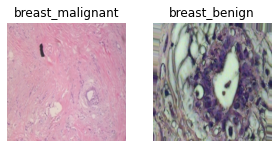

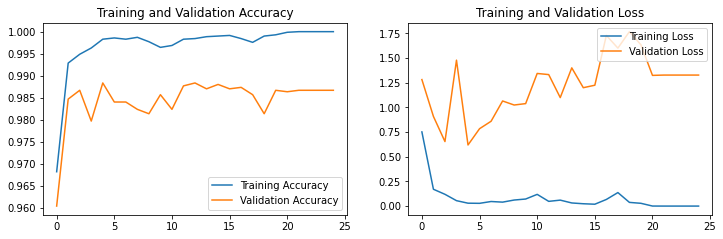

94/94 [==============================] - 12s 127ms/step - loss: 1.3274 - accuracy: 0.9867
Accuracy on the Test Set = 98.67 %
Model Saved!
True :  [0 0 0 ... 1 1 1]
Predicted :  [0 0 0 ... 1 1 1]


<Figure size 432x288 with 0 Axes>

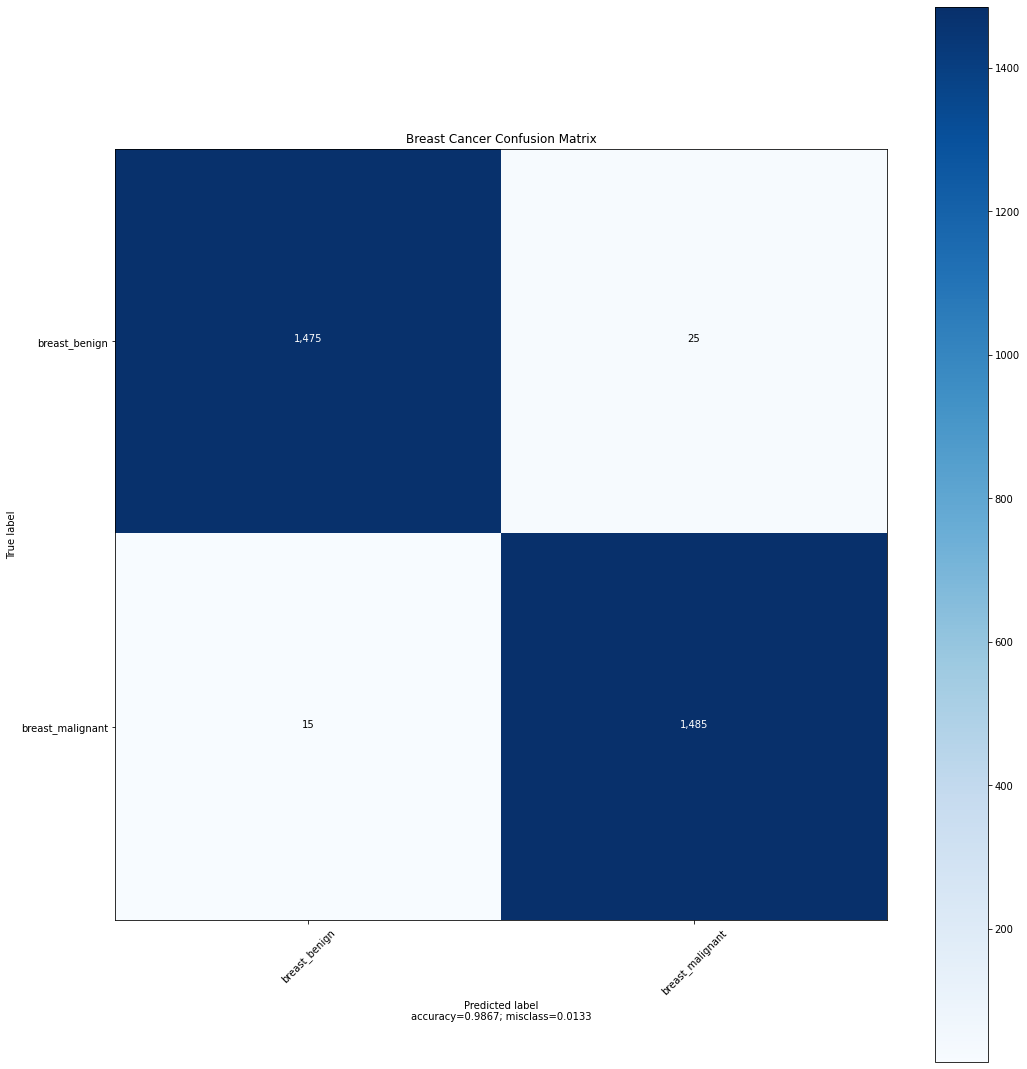

<Figure size 432x288 with 0 Axes>

In [17]:
className = 'Breast Cancer '
cpath = os.path.join(mpath, 'Breast Cancer')
noOfClasses, class_names, train_generator, validation_generator = initiateGenerator(cpath)
curModel = initiateModel(noOfClasses)
modelSummary(curModel)
curModel, annealer, checkpoint = initiateParams(className, curModel, lr)
curHistory = modelFit(curModel, annealer, checkpoint, epochs=gEpochs, batchSize=256)
plotOutput(curHistory, className, gEpochs)
evalModel(curModel)
saveModel(curModel, className)
callPlot(curModel, className, class_names)


Total :  Found 20000 files belonging to 4 classes.

For Training :  Found 14000 images belonging to 4 classes.

For Val :  Found 6000 images belonging to 4 classes.

No of Classes :  4
Classes :  ['all_benign', 'all_early', 'all_pre', 'all_pro']
Image Shape :  (32, 256, 256, 3)
Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 11

438/438 [==============================] - 68s 155ms/step - loss: 0.0316 - accuracy: 0.9992 - val_loss: 0.5220 - val_accuracy: 0.9935

Epoch 00025: val_loss did not improve from 0.23009


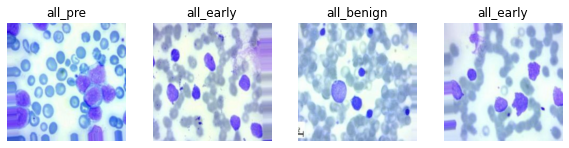

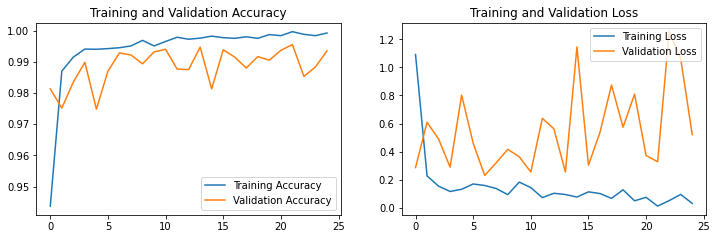

188/188 [==============================] - 21s 110ms/step - loss: 0.5220 - accuracy: 0.9935
Accuracy on the Test Set = 99.35 %
Model Saved!
True :  [0 0 0 ... 3 3 3]
Predicted :  [0 0 0 ... 3 3 3]


<Figure size 432x288 with 0 Axes>

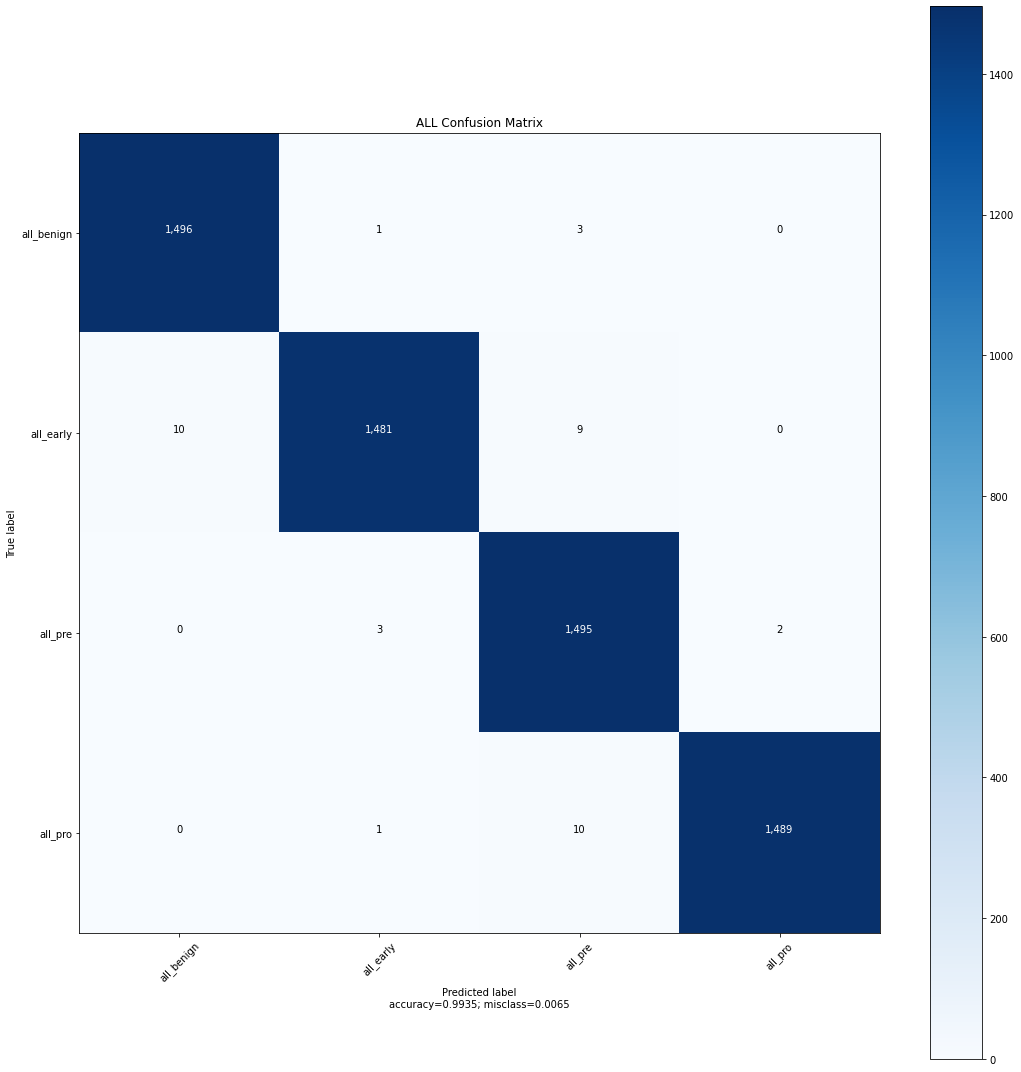

<Figure size 432x288 with 0 Axes>

In [18]:
className = 'ALL '
cpath = os.path.join(mpath, 'ALL')
noOfClasses, class_names, train_generator, validation_generator = initiateGenerator(cpath)
curModel = initiateModel(noOfClasses)
modelSummary(curModel)
curModel, annealer, checkpoint = initiateParams(className, curModel, lr)
curHistory = modelFit(curModel, annealer, checkpoint, epochs=gEpochs, batchSize=128)
plotOutput(curHistory, className, gEpochs)
evalModel(curModel)
saveModel(curModel, className)
callPlot(curModel, className, class_names)